<a href="https://colab.research.google.com/github/jp2011/mcmc-examples/blob/main/MCMC_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os
from pathlib import Path
import traceback

import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [2]:
A4_SIZE_X = 8.25
A4_SIZE_Y = 11.75

In [3]:
class MomentumDistribution:
    def __init__(self, mass_matrix_diag):
        self.mass_matrix_diag = mass_matrix_diag
        self.mass_matrix_inv_diag = 1 / mass_matrix_diag

    def sample(self):
        n = self.mass_matrix_diag.shape[0]
        standard_normal_samples = np.random.normal(size=n)
        mass_matrix_diag_sqrt = np.sqrt(self.mass_matrix_diag)
        return np.multiply(standard_normal_samples, mass_matrix_diag_sqrt)

    def log_pdf(self, phi):
        return -0.5 * np.dot(phi, np.multiply(self.mass_matrix_inv_diag, phi))

    def mass_inverse_mvm(self, phi):
        result = np.multiply(self.mass_matrix_inv_diag, phi)
        return result


class HMCSampler:

    def __init__(self, *, func_lpdf=None, func_nabla_lpdf=None, func_plot=None,
                 init_estimand=None, init_M_diag=None, init_L=100, init_epsilon=0.01,
                 n_burnin=20_000, n_calib=40_000, S=80_000, n_info_interval=500, thinning=5,
                 unique_estimation_id=0,
                 save_samples=False, adaptive=False):

        self.uid = unique_estimation_id
        self.thinning = thinning

        self.func_lpdf = func_lpdf
        self.func_nabla_lpdf = func_nabla_lpdf
        self.func_plot = func_plot

        self.estimand = init_estimand
        self.L = init_L
        self.epsilon = init_epsilon
        self.adaptive = adaptive
        self.save_samples = save_samples

        self.S = S
        self.n_info_interval = n_info_interval
        self.n_calib = n_calib
        self.n_burnin = n_burnin
        self.adjust_interval_calib = 100
        self.adjust_interval_burnin = 100

        self.s = 0
        self.samples = []
        self.total_samples = 0
        self.accepted_samples = 0
        self.samples = []
        self.likelihood_samples = []

        self.momentum = MomentumDistribution(init_M_diag)
        self.logger = logging.getLogger(__name__)

    def reset_counters(self):
        self.samples = []
        self.total_samples = 0
        self.accepted_samples = 0
        self.samples = []
        self.likelihood_samples = []

    def snapshot(self):
        file_name = f"hmc-samples--{self.uid}--{self.s}"
        full_path = Path(os.getcwd()) / "models" / "snapshots" / file_name
        self.__save_output(full_path)

    def __save_output(self, full_path_to_file):
        # check if the directory exists, if not create it
        directory = os.path.dirname(full_path_to_file)
        if not os.path.exists(directory):
            os.makedirs(directory)

        hmc_samples_array = np.asarray(self.samples)
        np.save(full_path_to_file, hmc_samples_array[::self.thinning,:])

    def adjust_leapfrogging(self):
        if self.total_samples > 0:
            acceptance = self.accepted_samples / self.total_samples

            leapfrog_prod = 1

            if acceptance > 0.80 or acceptance < 0.50:
                change_sign = np.sign(acceptance - 0.65)
                self.epsilon = self.epsilon + change_sign * 0.1 * self.epsilon

                # This can cause problems for certain scenarios
                if self.adaptive:
                    self.L = int(leapfrog_prod / self.epsilon) + 1

                self.reset_counters()

                self.logger.info(f"Iteration {self.s}, AR: {acceptance:0.4f}, adjusted to L={self.L}, ε={self.epsilon:0.4f}")

    def adjust_momentum(self):
        if self.total_samples > 0:
            hmc_samples = np.asarray(self.samples)
            cov_estim = np.cov(hmc_samples.T)
            self.momentum = MomentumDistribution(1 / np.diag(cov_estim))
            self.reset_counters()

    def sample_one(self):
        #### BURN-IN ####
        if self.s == self.n_burnin:
            self.reset_counters()

        #### REPORTING ####
        if (self.s + 1) % self.n_info_interval == 0:
            self.logger.info(f"Iteration {self.s}, AR: {self.accepted_samples / self.total_samples:0.3f}")
            if self.save_samples:
                self.snapshot()

        #### ADJUSTMENTS ####
        # adjustment L-epsilon
        if self.s < self.n_burnin and (self.s + 1) % self.adjust_interval_burnin == 0:
            self.adjust_leapfrogging()

        if self.s < self.n_calib + self.n_burnin and (self.s + 1) % self.adjust_interval_calib == 0:
            self.adjust_leapfrogging()

        # calibration of the mass matrix
        if self.s == self.n_calib - 1:
            self.adjust_momentum()

        #### SAMPLING CORE ####
        phi = self.momentum.sample()
        phi_star = phi.copy()
        estimand = self.estimand
        estimand_star = estimand.copy()

        try:
            for leapfrog_iter in range(self.L):
                if leapfrog_iter == 0:
                    phi_star = phi_star + 0.5 * self.epsilon * self.func_nabla_lpdf(estimand_star)

                estimand_star = estimand_star + self.epsilon * self.momentum.mass_inverse_mvm(phi_star)

                if leapfrog_iter != self.L - 1:
                    phi_star = phi_star + 1 * self.epsilon * self.func_nabla_lpdf(estimand_star)
                else:
                    phi_star = phi_star + 0.5 * self.epsilon * self.func_nabla_lpdf(estimand_star)

            if np.any(np.isinf(phi_star)) or np.any(np.isnan(phi_star)):
                self.logger.debug("Φ* is NaN or Inf")

            if not np.any(np.isinf(phi_star)) and not np.any(np.isnan(phi_star)):
                likelihood = self.func_lpdf(estimand)
                likelihood_star = self.func_lpdf(estimand_star)

                mom_lpdf = self.momentum.log_pdf(phi)
                mom_star_lpdf = self.momentum.log_pdf(phi_star)

                ratio = np.exp(likelihood_star + mom_star_lpdf - likelihood - mom_lpdf)
                self.logger.debug(
                    f"Iteration {self.s},\tLL*: {likelihood_star:.2f},\tΦ*: {mom_star_lpdf:.2f},\tLL: {likelihood:.2f},\tΦ: {mom_lpdf:.2f}\tR:{ratio:.2f}")
                if ratio > np.random.uniform(0, 1):
                    estimand = estimand_star
                    self.accepted_samples += 1

        except np.linalg.LinAlgError as error:
            self.logger.warning(f"Failed to sample: {error}")
        except Exception as e:
            self.logger.warning(f"Failed to sample: {e}")
            self.logger.error(f"{traceback.format_exc()}")

        self.total_samples += 1
        self.estimand = estimand
        self.samples.append(estimand)
        self.likelihood_samples.append(self.func_lpdf(estimand))
        self.s += 1

    def sample(self):
        while self.s < self.S:
            self.sample_one()

        if self.save_samples:
            self.snapshot()

In [4]:
rho = 0.9

Sigma = np.asarray([[1.0, rho], [rho, 1.0]])
Sigma_inv = (1.0 / (1.0 - rho ** 2)) * np.asarray([[1.0, -rho], [-rho, 1.0]])

def logpdf(x):
    return -0.5 * np.dot(x, np.dot(Sigma_inv, x))

def logpdf_nabla_x(x):
    return - np.dot(Sigma_inv, x)

In [5]:
S_hmc = 100_000
hmc_sampler = HMCSampler(func_lpdf=logpdf, func_nabla_lpdf=logpdf_nabla_x, func_plot=None,
                         init_estimand=np.zeros(2), init_M_diag=1e-1*np.ones(2), init_L=100, init_epsilon=0.01,
                         n_burnin=int(0.5*S_hmc), n_calib=int(0.1*S_hmc), S=S_hmc, n_info_interval=500, thinning=1,
                         unique_estimation_id=0,
                         save_samples=False, adaptive=True)
hmc_sampler.sample()

Streaming output truncated to the last 5000 lines.
DEBUG:__main__:Iteration 66086,	LL*: -0.64,	Φ*: -0.02,	LL: -0.20,	Φ: -0.16	R:0.74
DEBUG:__main__:Iteration 66087,	LL*: -0.25,	Φ*: -0.96,	LL: -0.20,	Φ: -1.06	R:1.05
DEBUG:__main__:Iteration 66088,	LL*: -1.69,	Φ*: -0.39,	LL: -0.25,	Φ: -0.74	R:0.34
DEBUG:__main__:Iteration 66089,	LL*: -0.97,	Φ*: -0.65,	LL: -1.69,	Φ: -0.34	R:1.51
DEBUG:__main__:Iteration 66090,	LL*: -1.96,	Φ*: -1.61,	LL: -0.97,	Φ: -2.26	R:0.71
DEBUG:__main__:Iteration 66091,	LL*: -1.41,	Φ*: -0.06,	LL: -0.97,	Φ: -0.17	R:0.72
DEBUG:__main__:Iteration 66092,	LL*: -2.04,	Φ*: -0.28,	LL: -1.41,	Φ: -0.60	R:0.74
DEBUG:__main__:Iteration 66093,	LL*: -1.75,	Φ*: -0.08,	LL: -1.41,	Φ: -0.19	R:0.79
DEBUG:__main__:Iteration 66094,	LL*: -1.64,	Φ*: -0.17,	LL: -1.75,	Φ: -0.20	R:1.17
DEBUG:__main__:Iteration 66095,	LL*: -1.19,	Φ*: -0.22,	LL: -1.64,	Φ: -0.05	R:1.32
DEBUG:__main__:Iteration 66096,	LL*: -1.63,	Φ*: -0.07,	LL: -1.19,	Φ: -0.30	R:0.81
DEBUG:__main__:Iteration 66097,	LL*: -0.44,	Φ*:

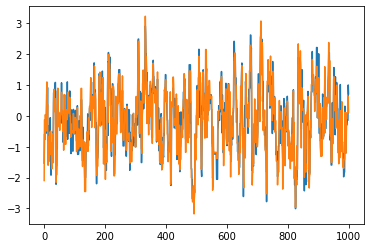

In [20]:
hmc_samples = np.asarray(hmc_sampler.samples)
plt.plot(hmc_samples[-1_000:, 0])
plt.plot(hmc_samples[-1_000:, 1])
plt.show()

# Metropolis-Hastings

In [7]:
S_mh = 100_000
rescaling_interval = 500
n_acc = 0
total = 0

initial_proposal_cov = np.asarray([[1, 0], [0, 1]])
x_curr = np.asarray([0.0, 0.0])

scaling = 1.0

chain = []

for i in range(S_mh):
    total += 1
    x_proposed = x_curr + scaling * np.random.multivariate_normal(mean=[0, 0], cov=initial_proposal_cov)
    ratio = np.exp(logpdf(x_proposed) - logpdf(x_curr))

    if np.random.uniform() < ratio:
        x_curr = x_proposed
        n_acc += 1
    chain.append(x_curr)
    
    if i % rescaling_interval == 0:
        ar = n_acc / total
        print(ar)
        
        if (ar < 0.22):
            scaling = 0.8 * scaling
            chain = []
            n_acc = 0
            total = 0
        elif ar > 0.24:
            scaling = 1.2 * scaling
            chain = []
            n_acc = 0
            total = 0     

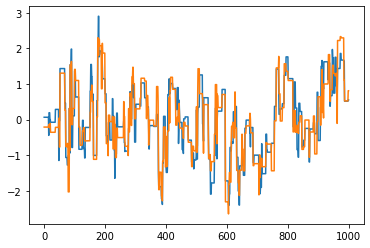

In [17]:
mh_samples = np.asarray(chain)
plt.plot(mh_samples[:1000, 0])
plt.plot(mh_samples[:1000, 1])
plt.show()

In [9]:
S_gibbs = 100_000
gibbs_trace = np.zeros([S_gibbs, 2])

x = 0.0
y = 0.0

for i in range(S_gibbs):
    x = np.random.normal(loc=rho * y, scale=np.sqrt(1 - rho**2))
    y = np.random.normal(loc=rho * x, scale=np.sqrt(1 - rho**2))
    gibbs_trace[i, :] = [x, y]

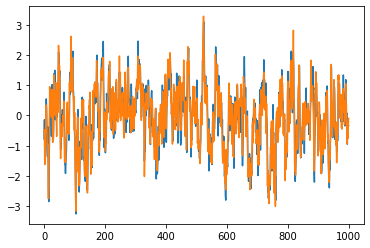

In [16]:
plt.plot(gibbs_trace[-1000:, 0])
plt.plot(gibbs_trace[-1000:, 1])
plt.show()

# Visualisations for the thesis

In [11]:
from scipy.stats import multivariate_normal
target_dist = multivariate_normal(mean=[0,0], cov=Sigma)

In [12]:
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)

X, Y = np.meshgrid(x, y)

def fun(x, y):
    z = np.zeros(x.shape)
    
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i, j] = target_dist.pdf([x[i, j], y[i, j]])

    return z

Z = fun(X, Y)

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2ddddfc9d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2ddddfc9d0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


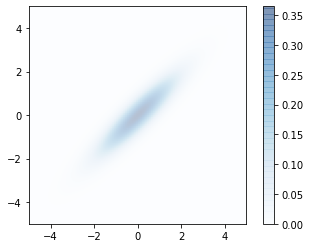

In [18]:
plt.imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='Blues', alpha=0.3)
plt.colorbar()
plt.axis();
plt.show()

In [14]:
num_steps_show = 200
num_trace_show = 1_000
num_acorr_lags = 20

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2dd6ecc610>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f2dd6ecc610>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.figure:Executing constrainedlayout
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000019.ss000020.ax000021, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:matplotlib._constrained_layout:left -0.036640
DEBUG:matplotlib._constrained_layout:right -0.073230
DEBUG:matplotlib._constrained_layout:bottom 0.023253
DEBUG:matplotlib._constrained_layout:bbox.y0 0.618123
DEBUG:matplotlib._constrained_layout:pos.y0 0.637830
DEBUG:matplotlib._constrained_layout:LayoutBox: gridspec000019.ss000022.ax000023, (left: 0.000) (bot: 0.000) (right: 0.000)  (top: 0.000) 
DEBUG:matplotlib._constrained_layout:left 0.041641
DEBUG:matplotlib._constrained_layout:

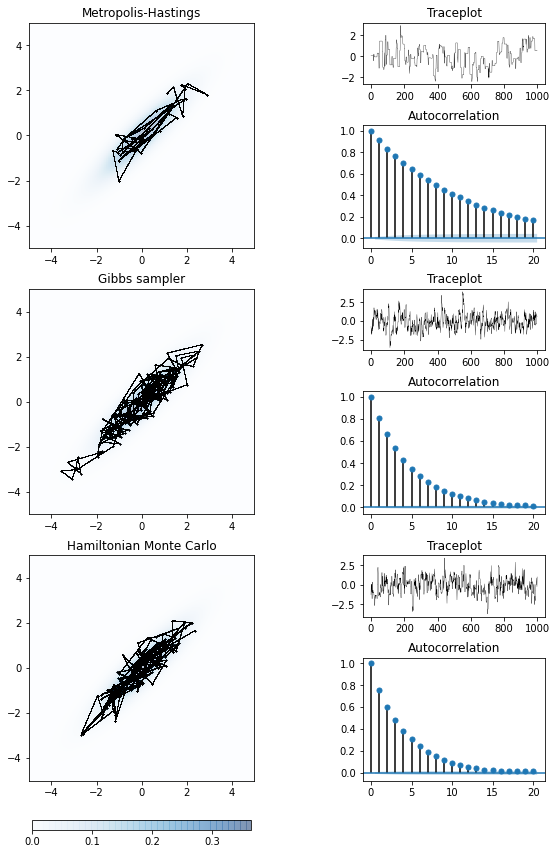

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(A4_SIZE_X, A4_SIZE_Y))
gs = fig.add_gridspec(9, 3)

ax_path_mh = fig.add_subplot(gs[0:3, 0:2])
ax_path_mh.imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='Blues', alpha=0.3)
for i in range(num_steps_show):
    ax_path_mh.plot(mh_samples[:num_steps_show, 0], mh_samples[:num_steps_show, 1], ".-k", linewidth=0.1, ms=0.1, alpha=0.5)
ax_path_mh.set_title("Metropolis-Hastings")

ax_trace_mh = fig.add_subplot(gs[0:1, 2:3])
ax_trace_mh.plot(mh_samples[:num_trace_show, 0], '-k', linewidth=0.3, alpha=1.0)
ax_trace_mh.set_title("Traceplot")

ax_acorr_mh = fig.add_subplot(gs[1:3, 2:3])
sm.graphics.tsa.plot_acf(mh_samples[:, 1], lags=num_acorr_lags, ax=ax_acorr_mh)
 

ax_path_gibbs = fig.add_subplot(gs[3:6, 0:2])
ax_path_gibbs.imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='Blues', alpha=0.3)
for i in range(num_steps_show):
    ax_path_gibbs.plot(gibbs_trace[:num_steps_show, 0], gibbs_trace[:num_steps_show, 1], ".-k", linewidth=0.1, ms=0.1, alpha=0.5)
ax_path_gibbs.set_title("Gibbs sampler")

ax_trace_gibbs = fig.add_subplot(gs[3:4, 2:3])
ax_trace_gibbs.plot(gibbs_trace[:num_trace_show, 0], '-k', linewidth=0.3, alpha=1.0)
ax_trace_gibbs.set_title("Traceplot")

ax_acorr_gibbs = fig.add_subplot(gs[4:6, 2:3])
sm.graphics.tsa.plot_acf(gibbs_trace[:, 1], lags=num_acorr_lags, ax=ax_acorr_gibbs)


ax_path_hmc = fig.add_subplot(gs[6:9, 0:2])
pcm = ax_path_hmc.imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap='Blues', alpha=0.3)
for i in range(num_steps_show):
    ax_path_hmc.plot(hmc_samples[:num_steps_show, 0], hmc_samples[:num_steps_show, 1], ".-k", linewidth=0.1, ms=0.1, alpha=0.5)
ax_path_hmc.set_title("Hamiltonian Monte Carlo")

ax_trace_hmc = fig.add_subplot(gs[6:7, 2:3])
ax_trace_hmc.plot(hmc_samples[:num_trace_show, 0], '-k', linewidth=0.3, alpha=1.0)
ax_trace_hmc.set_title("Traceplot")

ax_acorr_hmc = fig.add_subplot(gs[7:9, 2:3])
sm.graphics.tsa.plot_acf(hmc_samples[:, 1], lags=num_acorr_lags, ax=ax_acorr_hmc)


fig.colorbar(pcm, ax=[ax_path_hmc], location='bottom', shrink=0.6)
    
plt.savefig("stat-inf-background-correlated-example-mcmc-comparison.pdf")
plt.show()


# ax_0 = fig.add_subplot(gs[0, 0])
# ax_0.set_ylabel("PMVB\n$\kappa(x)$")
# ax_0.set_title('$\mathrm{bandwidth}=4$')
# kappa_mean_mfvb = output_0['mean']
# kappa_std_mfvb = np.sqrt(np.diag(output_0['cov']))
# ax_0.plot(fem.get_param_coords()[:, 0], kappa_mean_mfvb , 'k-')
# ax_0.fill_between(fem.get_param_coords()[:, 0], kappa_mean_mfvb-2*kappa_std_mfvb, kappa_mean_mfvb+2*kappa_std_mfvb, alpha=0.2)
# ax_0.plot(fem.get_param_coords()[:, 0], output_0['true_kappa'], "r-")
# ax_0.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# ax_10 = fig.add_subplot(gs[0, 1], sharey=ax_0)
# ax_10.set_title('$\mathrm{bandwidth}=10$')
# plt.setp(ax_10.get_yticklabels(), visible=False)
# kappa_mean_mfvb = output_10['mean']
# kappa_std_mfvb = np.sqrt(np.diag(output_10['cov']))
# ax_10.plot(fem.get_param_coords()[:, 0], kappa_mean_mfvb , 'k-')
# ax_10.fill_between(fem.get_param_coords()[:, 0], kappa_mean_mfvb-2*kappa_std_mfvb, kappa_mean_mfvb+2*kappa_std_mfvb, alpha=0.2)
# ax_10.plot(fem.get_param_coords()[:, 0], output_10['true_kappa'], "r-")

# ax_20 = fig.add_subplot(gs[0, 2], sharey=ax_0)
# ax_20.set_title('$\mathrm{bandwidth}=20$')
# plt.setp(ax_20.get_yticklabels(), visible=False)
# kappa_mean_mfvb = output_20['mean']
# kappa_std_mfvb = np.sqrt(np.diag(output_20['cov']))
# ax_20.plot(fem.get_param_coords()[:, 0], kappa_mean_mfvb , 'k-')
# ax_20.fill_between(fem.get_param_coords()[:, 0], kappa_mean_mfvb-2*kappa_std_mfvb, kappa_mean_mfvb+2*kappa_std_mfvb, alpha=0.2)
# ax_20.plot(fem.get_param_coords()[:, 0], output_20['true_kappa'], "r-")


# plt.suptitle(f"True $\ell_\kappa=${true_lengthscale}, Prior $\ell_\kappa=${prior_lengthscale}")

# plt.savefig(plots_folder / f"poisson-1d--precision-multi-bandwidth--inf-seed-{inference_seed}--true-len-{true_lengthscale}-prior-len-{prior_lengthscale}.pdf")        
# plt.show()